## TWO-LAYER NEURAL NETWORK CODING AND APPLICATION

### Description

- Build a 2-layer neural network model with the following structure: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> PREDICT OUTPUT.
- Use the trained model to classify cat or non-cat images from the dataset.
- Make predictions on the training and test set, and my own images.

#### 1. Load libraries and dataset

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2

In [3]:
np.random.seed(1)

In [4]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

#### 2. Data Exploration

y = 0. It's a non-cat picture.


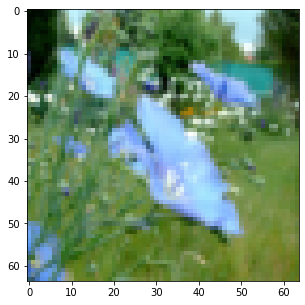

In [6]:
# Example of a picture in dataset
index = 20

plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.imshow(train_x_orig[index])

print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") + " picture.")

In [7]:
print(train_x_orig.shape)
print(train_y.shape)
print(test_x_orig.shape)
print(test_y.shape)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)


In [8]:
print(classes)

[b'non-cat' b'cat']


In [9]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

In [10]:
print(m_train)
print(num_px)
print(m_test)

209
64
50


In [11]:
print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


#### 3. Preprocessing data

In [12]:
# Reshape & standardize the training and test samples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T  # The "-1" makes reshape flatten the remaining dimensions
print(train_x_flatten.shape)
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
print(test_x_flatten.shape)

(12288, 209)
(12288, 50)


In [13]:
# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


#### 4. Define some helpful functions

In [14]:
# Two-layer neural network: CONSTANTS DEFINING THE MODEL
n_x = 12288     # num_px * num_px * 3 (64*64*3)
n_h = 7 # num of hidden units = 7 (can adjust unit to 3,5,10,13,...)
n_y = 1 # num of output unit = 1
layers_dims = (n_x, n_h, n_y) # (12288,7,1)

In [15]:
# Initialize parameters:
def initialize_parameters(n0, n1, n2):
    """ Initialize W1, b1, W2, b2
    n0: dimension of input data
    n1: number of hidden unit
    n2: number of output unit = number of classes
    """
    W1 = 0.01*np.random.randn(n1, n0)
    b1 = np.zeros((n1,1))
    W2 = 0.01*np.random.randn(n2, n1)
    b2 = np.zeros((n2,1))
    return W1, b1, W2, b2

In [16]:
W1, b1, W2, b2 = initialize_parameters(n_x,n_h,n_y)

In [17]:
print(W1.shape)
print(b1.shape)
print(W2.shape)
print(b2.shape)

(7, 12288)
(7, 1)
(1, 7)
(1, 1)


In [18]:
# Activation functions
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_grad(z):
    return sigmoid(z)*(1-sigmoid(z))

def softmax_stable(Z):
    """
    Compute softmax values for each sets of scores in Z, each ROW of Z is a set of scores.
    
    """
    e_Z = np.exp(Z - np.max(Z, axis = 1, keepdims = True))
    A = e_Z / e_Z.sum(axis = 1, keepdims = True)
    return A

def ReLu(z):
    return np.maximum(z,0)

# def dReLU(x):
#     return 1.0 * (x > 0)

def ReLu_grad(z):
    z[z <= 0] = 0
    z[z > 0] = 1
    return z

def LeakyReLu(x,eta=0.01):
    return abs(eta*x)*(x>0)

def dLeakyReLu(x, eta=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = eta
    return dx

In [19]:
def loss_function(Yhat, y):
    """
    Y-hat: a numpy array of shape (N-points, n-Classes) --- predicted output
    y: a numpy array of shape (N-points) --- ground truth.
    
    """
    # id0 = range(Yhat.shape[0])
    # return -np.mean(np.log(Yhat[id0, y])) # cross_entropy loss function
    return -np.mean(y*np.log(Yhat) + (1-y)*np.log(1-Yhat)) # logistic loss function

In [20]:
# Regularization
def regularized_loss(Yhat, y, lambd):
    m = y.shape[1]
    loss = -np.mean(y*np.log(Yhat) + (1-y)*np.log(1-Yhat))
    L2_reg = lambd/(2*m)*(np.sum(np.square(W1))+np.sum(np.square(W2)))
    cost = loss + L2_reg
    
    return cost

In [21]:
def predict(X, W1, b1, W2, b2, activation):
    """
    Suppose the network has been trained, predict class of new points.
    X: data matrix, each ROW is one data point.
    W1, b1, W2, b2: trained weight matrices and biases
    
    """
    Z1 = np.dot(W1,X) + b1 # shape (N, d1)
    if activation == 'relu':
        A1 = ReLu(Z1)
    elif activation == 'sigmoid':
        A1 = sigmoid(Z1) # shape (N, d1)
    else:
        A1 = LeakyReLu(Z1)
    Z2 = np.dot(W2,A1) + b2 # shape (N, d2)
    
    return sigmoid(Z2)

In [22]:
# decide predicted class is 0 or 1
def separate(p,x):
    p = p.reshape(x.shape[1],)
    for i in range(len(p)):
        if p[i] >= 0.5: 
            p[i] = 1
        else:
            p[i] = 0
            
    return p

In [23]:
# Evaluate model accuracy
def evaluate(p,y):
    y = y.reshape(y.shape[1],)
    acc = 100*np.mean(p == y)
    print("Accuracy = ", acc)
    
    return acc

In [24]:
# Train model
def training_model(X,y,W1,b1,W2,b2,activation,num_iter,lambd,alpha = 0.005):
    loss_hist = []
    for i in range(num_iter):
        # Forward propagation:
        Z1 = np.dot(W1,X) + b1
        if activation == 'relu':
            A1 = ReLu(Z1)
        elif activation == 'sigmoid':
            A1 = sigmoid(Z1)
        else:
            A1 = LeakyReLu(0.01, Z1)
        Z2 = np.dot(W2,A1) + b2
        A2 = sigmoid(Z2)
        # regularize
        if lambd == 0:
            loss = loss_function(A2,y)
        else:
            loss = regularized_loss(A2,y,lambd)
        # print loss after each 1000 iterations
        if i %100 == 0: 
            # loss = loss_function(A2, y)
            print("iter %d, loss: %f" %(i, loss))
        loss_hist.append(loss)
        
        # Back propagation:
        dZ2 = A2 - y
        if lambd == 0:
            dW2 = 1/m_train*np.dot(dZ2,A1.T)
        else:
            dW2 = 1/m_train*np.dot(dZ2,A1.T) + (lambd/m_train)*W2
        db2 = 1/m_train*np.sum(dZ2, axis = 1, keepdims = True)
        if activation == 'relu':
            # dZ1 = np.dot(W2.T,dZ2)
            # dZ1[Z1 <= 0] = 0 # relu gradient
            dZ1 = np.dot(W2.T,dZ2)*ReLu_grad(Z1)
        elif activation == 'sigmoid':
            dZ1 = np.dot(W2.T,dZ2)*sigmoid_grad(Z1)
        else:
            dZ1 = np.dot(W2.T,dZ2)*dLeakyReLu(Z1,0.01)
        if lambd == 0:
            dW1 = 1/m_train*np.dot(dZ1,train_x.T)
        else:
            dW1 = 1/m_train*np.dot(dZ1,train_x.T) + (lambd/m_train)*W1
        db1 = 1/m_train*np.sum(dZ1,axis = 1, keepdims = True)

        W1 += -alpha*dW1
        b1 += -alpha*db1
        W2 += -alpha*dW2
        b2 += -alpha*db2

    # Plot loss hist
    plt.figure(figsize=(10,6))
    plt.plot(np.squeeze(loss_hist))
    plt.grid()
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.title("Learning rate =" + str(alpha))
    plt.show()

    return (W1,b1,W2,b2), loss_hist

#### 5. Train model

iter 0, loss: 0.693050
iter 100, loss: 0.646432
iter 200, loss: 0.632514
iter 300, loss: 0.601502
iter 400, loss: 0.560197
iter 500, loss: 0.515830
iter 600, loss: 0.475490
iter 700, loss: 0.433916
iter 800, loss: 0.400798
iter 900, loss: 0.358071
iter 1000, loss: 0.339428
iter 1100, loss: 0.305275
iter 1200, loss: 0.274914
iter 1300, loss: 0.246818
iter 1400, loss: 0.198507
iter 1500, loss: 0.174483
iter 1600, loss: 0.170808
iter 1700, loss: 0.113065
iter 1800, loss: 0.096294
iter 1900, loss: 0.083426
iter 2000, loss: 0.074391
iter 2100, loss: 0.066307
iter 2200, loss: 0.059193
iter 2300, loss: 0.053361
iter 2400, loss: 0.048555
iter 2500, loss: 0.044141
iter 2600, loss: 0.040346
iter 2700, loss: 0.036841
iter 2800, loss: 0.033660
iter 2900, loss: 0.030756


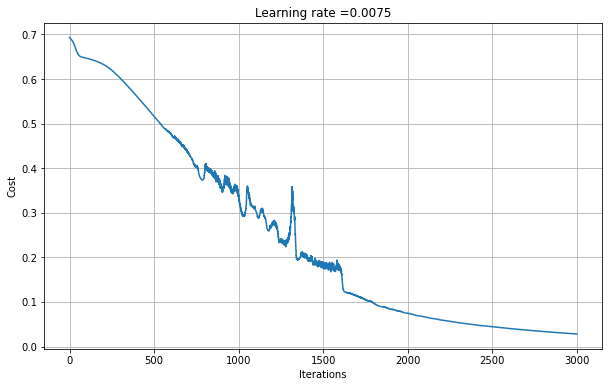

In [25]:
parameters, cost = training_model(train_x,train_y,W1,b1,W2,b2,activation = 'relu',num_iter = 3000,alpha = 0.0075, lambd = 0)

#### 6. Save model

In [37]:
# Save model:
from pickle import dump

filename = './saved_models/2-layer-model.sav'
dump(parameters, open(filename, 'wb'))

In [ ]:
# Load saved model:
from pickle import load

parameters = load(open('2-layer-model.sav', 'rb'))

#### 7. Evaluation

In [26]:
# EVALUATE ON TRAINING SET
pred = predict(train_x,W1,b1,W2,b2,activation = 'relu')
p = separate(pred,train_x)
acc = evaluate(p,train_y)
# EVALUATE ON TEST SET
pred_test = predict(test_x,W1,b1,W2,b2,activation = 'relu')
p = separate(pred_test,test_x)
acc = evaluate(p,test_y)

Accuracy =  100.0
Accuracy =  72.0


#### 8. Result analysis

In [27]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (30.0, 30.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

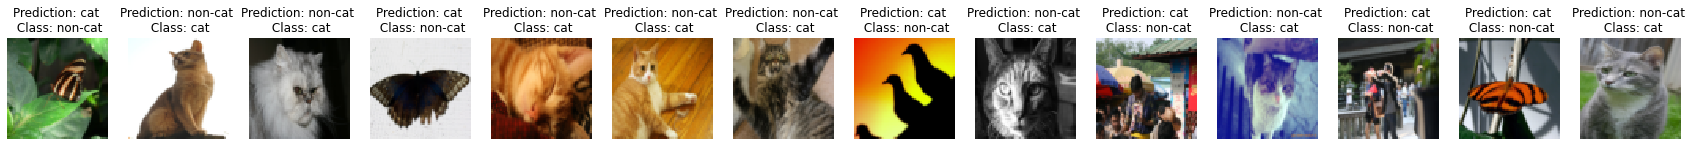

In [28]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

A few type of images the model tends to do poorly on include:

• Cat body in an unusual position

• Cat appears against a background of a similar color

• Unusual cat color and species

• Camera angle

• Brightness of the picture

• Scale variation (cat is very large or small in image)

#### 9. Predict new images

(262, 400, 3)


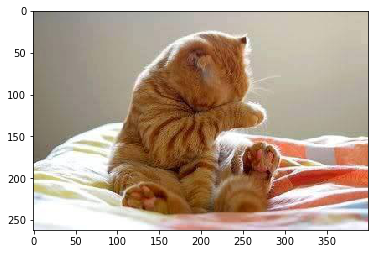

In [29]:
# Load and show my new image
from PIL import Image

image = np.array(Image.open("./images/test.jpg"))

# Obtain the size of the image
print(image.shape)

plt.figure(figsize=(6,6))
plt.imshow(image)

In [176]:
# lOAD, RESIZE & STANDARDIZE IMAGE

# my_image = "./images/test.jpg" # change this to the name of your image file
# my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
# image = np.array(cv2.imread(my_image))
# plt.figure(figsize=(10,10))
# plt.imshow(image)

# from skimage import io, transform

# image = image/255.
# resizedImage = transform.resize(image,dim)
# print(resizedImage.shape)
# plt.figure(figsize=(10,10))
# plt.imshow(resizedImage)

# resizedImage = resizedImage.reshape((num_px*num_px*3,1))
# predicted_image = predict(resizedImage,W1,b1,W2,b2,activation = 'relu')
# my_predicted_image = separate(my_predicted_image,my_image)
# print ("y = " + str(np.squeeze(my_predicted_image)) + ", your 2-layer nn model predicts this is a \"" + 
#     classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

In [30]:
# Standardize image for prediction
image = image/255.
dim = (num_px, num_px)
my_image = cv2.resize(image,dim)
my_image = my_image.reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image,W1,b1,W2,b2,activation = 'relu')

In [31]:
print('Prediction output: ', my_predicted_image[[0][0]])
my_predicted_image = separate(my_predicted_image,my_image)

Prediction output:  [0.8937715]


In [32]:
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your 2-layer nn model predicts this is a \"" + 
    classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 1.0, your 2-layer nn model predicts this is a "cat" picture.


##### The model has predicted exactly my images, let's test with another non-cat image.

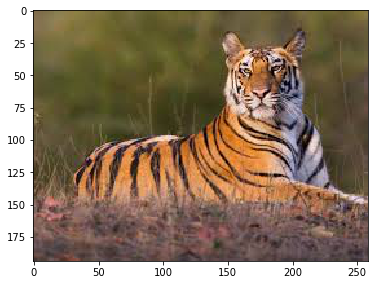

In [33]:
# Open my non-cat image
image = np.array(Image.open("./images/tiger.jpg"))

plt.figure(figsize=(6,6))
plt.imshow(image)

In [34]:
# Standardize image for prediction
image = image/255.
dim = (num_px, num_px)
my_image = cv2.resize(image,dim)
my_image = my_image.reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image,W1,b1,W2,b2,activation = 'relu')

In [35]:
print('Prediction output: ', my_predicted_image[[0][0]])
my_predicted_image = separate(my_predicted_image,my_image)

print ("y = " + str(np.squeeze(my_predicted_image)) + ", your 2-layer nn model predicts this is a \"" + 
    classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Prediction output:  [0.38800563]
y = 0.0, your 2-layer nn model predicts this is a "non-cat" picture.


##### Well done! This is tiger, not a cat picture!